# Fishing Vessel Extended Loitering Model Development

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import TimeSeriesSplit, RandomizedSearchCV
from sklearn.metrics import (confusion_matrix, precision_score, recall_score,
                            f1_score, roc_auc_score, auc, precision_recall_curve,
                            matthews_corrcoef, mean_squared_error)

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier

# Set random state
RANDOM_STATE = 778
np.random.seed(RANDOM_STATE)

The history saving thread hit an unexpected error (OperationalError('attempt to write a readonly database')).History will not be written to the database.


In [22]:
data = pd.read_csv('data/final_data/final_data.csv')

In [ ]:
### Functions to be used throughout notebook
# Preprocess the data
def preprocess_data(df):
    """
    Preprocess the data for model training.
    """
    # Create a copy to avoid modifying the original dataframe
    df = df.copy()

    # Convert timestamp and ensure dates are sorted
    df['event_date'] = pd.to_datetime(df['event_date'])
    df = df.sort_values('event_date').reset_index(drop=True)

    # One-hot encode categorical columns
    categorical_cols = ['vessel_info_flag', 'event_info_origin_port.iso', 'event_info_destination_port.iso']
    df = pd.get_dummies(df, columns=categorical_cols, drop_first=True)

    # Define features and target
    target = 'extended_loitering'
    features = df.columns.difference([target, 'event_date'])

    # Remove multicollinearity
    corr_matrix = df[features].corr().abs()
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
    to_drop = [column for column in upper.columns if any(upper[column] > 0.8)]
    features = features.difference(to_drop)
    df = df.drop(columns=to_drop)

    return df, features, target


# Create evaluation metrics function
def evaluate_model(y_true, y_pred, y_pred_proba):
    """
    Calculate various metrics for model evaluation.
    """
    metrics = {
        'accuracy': accuracy_score(y_true, y_pred),
        'precision': precision_score(y_true, y_pred),
        'recall': recall_score(y_true, y_pred),
        'f1': f1_score(y_true, y_pred),
        'pr_auc': average_precision_score(y_true, y_pred_proba),
        'mcc': matthews_corrcoef(y_true, y_pred),
    }

    conf_matrix = confusion_matrix(y_true, y_pred)

    return metrics, conf_matrix


# Preprocess data
df_processed, features, target = preprocess_data(data)

## Initial Model Evaluation

In [ ]:
# Model training and evaluation function
def train_and_evaluate_models(df, features, target, n_splits=5):
    # Initialize TimeSeriesSplit with custom parameters
    tscv = TimeSeriesSplit(n_splits=n_splits, max_train_size=None)

    # Initialize models
    models = {
        'Logistic Regression': LogisticRegression(class_weight='balanced', random_state=RANDOM_STATE, max_iter=1000),
        'Decision Tree': DecisionTreeClassifier(class_weight='balanced', random_state=RANDOM_STATE),
        'Random Forest': RandomForestClassifier(class_weight='balanced', n_estimators=100, random_state=RANDOM_STATE),
        'Gradient Boosting': GradientBoostingClassifier(random_state=RANDOM_STATE),
        'KNN': KNeighborsClassifier(n_neighbors=5)
    }

    # Prepare data
    X = df[features].values
    y = df[target].values

    # Store results
    results = {model_name: [] for model_name in models.keys()}
    confusion_matrices = {model_name: np.zeros((2, 2)) for model_name in models.keys()}

    # Perform cross-validation
    for train_idx, val_idx in tscv.split(X):
        X_train, X_val = X[train_idx], X[val_idx]
        y_train, y_val = y[train_idx], y[val_idx]

        # Scale features within the fold
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_val_scaled = scaler.transform(X_val)

        for model_name, model in models.items():
            # Train model
            model.fit(X_train_scaled, y_train)

            # Make predictions
            y_pred = model.predict(X_val_scaled)
            y_pred_proba = model.predict_proba(X_val_scaled)[:, 1]

            # Calculate metrics
            metrics, conf_matrix = evaluate_model(y_val, y_pred, y_pred_proba)
            results[model_name].append(metrics)
            confusion_matrices[model_name] += conf_matrix

    # Average results across folds
    final_results = {}
    for model_name in models.keys():
        model_metrics = pd.DataFrame(results[model_name])
        final_results[model_name] = model_metrics.mean()

    return final_results, confusion_matrices


# Function to plot confusion matrices
def plot_confusion_matrices(confusion_matrices):
    n_models = len(confusion_matrices)
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    axes = axes.ravel()

    for idx, (model_name, conf_matrix) in enumerate(confusion_matrices.items()):
        if idx < len(axes):
            sns.heatmap(conf_matrix, annot=True, fmt='g', ax=axes[idx])
            axes[idx].set_title(f'{model_name} Confusion Matrix')
            axes[idx].set_xlabel('Predicted')
            axes[idx].set_ylabel('Actual')

    plt.tight_layout()
    return fig


# Train and evaluate models
results, confusion_matrices = train_and_evaluate_models(df_processed, features, target)

results_df = pd.DataFrame(results)

print(results_df)

fig = plot_confusion_matrices(confusion_matrices)

## Model Refining - Iteration 1: With different decision thresholds
Goal is to find a balance between Precision and Recall, and high F1 Score

False negatives (missed extended loitering predictions) and false positives (incorrect predictions of extended loitering) both have operational costs. Gradient boosting provides a good balance between precision and recall

In [ ]:
from sklearn.pipeline import Pipeline
from xgboost import XGBClassifier
from scipy.stats import randint, uniform
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                           f1_score, roc_auc_score, average_precision_score,
                           confusion_matrix)


def optimize_xgb_model(df, features, target, n_splits=5, n_iter=100):
    """
    Optimize Gradient Boosting model using RandomizedSearchCV with time series split.
    """
    # Prepare data
    X = df[features].values
    y = df[target].values

    # Define parameter space
    param_distributions = {
        'classifier__n_estimators': randint(100, 500),
        'classifier__learning_rate': uniform(0.01, 0.3),
        'classifier__max_depth': randint(3, 10),
        'classifier__subsample': uniform(0.6, 0.4),
        'classifier__colsample_bytree': uniform(0.6, 0.4),
        'classifier__scale_pos_weight': [float(np.sum(y == 0)) / np.sum(y == 1)]  # Ratio of negative to positive class
    }

    pipeline = Pipeline([
        ('classifier', XGBClassifier(random_state=RANDOM_STATE, eval_metric='logloss'))
    ])

    # Initialize TimeSeriesSplit
    tscv = TimeSeriesSplit(n_splits=n_splits)

    # Initialize RandomizedSearchCV
    random_search = RandomizedSearchCV(
        estimator=pipeline,
        param_distributions=param_distributions,
        n_iter=n_iter,
        cv=tscv,
        scoring='average_precision',
        random_state=RANDOM_STATE,
        n_jobs=-1,
        verbose=1
    )

    # Fit RandomizedSearchCV
    random_search.fit(X, y)

    return random_search.best_estimator_, random_search.best_params_


def evaluate_optimized_model(model, df, features, target, n_splits=5, threshold=0.5):
    """
    Evaluate the optimized model using time series cross-validation.

    Lower threshold will increase recall (catch more actual extended loitering events), but decrease precision (more false positive)
    """
    X = df[features].values
    y = df[target].values

    tscv = TimeSeriesSplit(n_splits=n_splits)
    results = []
    confusion_matrices = np.zeros((2, 2))
    feature_importances = []

    for train_idx, val_idx in tscv.split(X):
        X_train, X_val = X[train_idx], X[val_idx]
        y_train, y_val = y[train_idx], y[val_idx]

        # Scaling not needed for XGBoost
        X_train_scaled = X_train
        X_val_scaled = X_val

        # Fit the model
        model.fit(X_train_scaled, y_train)

        # Collect feature importances
        classifier = model.named_steps['classifier']
        feature_importances.append(classifier.feature_importances_)

        # Get probability predictions first
        y_pred_proba = model.predict_proba(X_val_scaled)[:, 1]

        # Apply custom threshold to probabilities
        y_pred = (y_pred_proba >= threshold).astype(int)

        metrics, conf_matrix = evaluate_model(y_val, y_pred, y_pred_proba)
        results.append(metrics)
        confusion_matrices += conf_matrix

    # Average metrics across folds
    avg_metrics = pd.DataFrame(results).mean()

    # Average feature importances across folds
    avg_feature_importance = np.mean(feature_importances, axis=0)
    feature_importance_df = pd.DataFrame(
        avg_feature_importance,
        index=features,
        columns=['importance']
    ).sort_values('importance', ascending=False)

    return avg_metrics, confusion_matrices, feature_importance_df

def plot_results(confusion_matrix, feature_importance):
    """
    Plot confusion matrix and feature importance.
    """
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

    # Plot confusion matrix
    sns.heatmap(confusion_matrix, annot=True, fmt='g', ax=ax1)
    ax1.set_title('Confusion Matrix')
    ax1.set_xlabel('Predicted')
    ax1.set_ylabel('Actual')

    # Plot top 15 feature importance
    feature_importance.head(15).plot(kind='barh', ax=ax2)
    ax2.set_title('Top 15 Feature Importance')
    ax2.set_xlabel('Importance')

    plt.tight_layout()
    return fig


# After getting best_model:
print("Optimizing XGBoost model...")
best_model, best_params = optimize_xgb_model(df_processed, features, target)
print("\nBest parameters found:")
for param, value in best_params.items():
    clean_param = param.replace('classifier__', '')
    print(f"{clean_param}: {value}")

# Add threshold testing here
thresholds = [0.3, 0.4, 0.5, 0.6, 0.7]
threshold_results = {}

for threshold in thresholds:
    metrics, conf_matrix, feature_importance = evaluate_optimized_model(
        best_model,
        df_processed,
        features,
        target,
        threshold=threshold
    )
    threshold_results[threshold] = {
        'metrics': metrics,
        'confusion_matrix': conf_matrix
    }

# Convert threshold results to a DataFrame for cleaner printing and plotting
threshold_metrics_df = pd.DataFrame({
    threshold: results['metrics'] for threshold, results in threshold_results.items()
}).T
print("\nResults for different thresholds (metrics by threshold):")
print(threshold_metrics_df)

# Plot threshold metrics side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Precision-Recall trade-off
threshold_metrics_df[['precision', 'recall']].plot(ax=ax1, marker='o')
ax1.set_title('Precision-Recall vs Threshold')
ax1.set_xlabel('Threshold')
ax1.set_ylabel('Score')
ax1.legend(title="Metrics")

# F1 Score and MCC
threshold_metrics_df[['f1', 'mcc']].plot(ax=ax2, marker='o')
ax2.set_title('F1 Score and MCC vs Threshold')
ax2.set_xlabel('Threshold')
ax2.set_ylabel('Score')
ax2.legend(title="Metrics")

plt.tight_layout()
plt.show()

# Choose best threshold based on F1 score
best_threshold = thresholds[np.argmax(f1_scores)]
print(f"\nBest threshold based on F1 score: {best_threshold}")

# Then proceed with your final evaluation using the best threshold
print("\nEvaluating optimized model with best threshold...")
metrics, conf_matrix, feature_importance = evaluate_optimized_model(
    best_model,
    df_processed,
    features,
    target,
    threshold=best_threshold
)

# Display final results
print("\nOptimized Model Performance Metrics (with best threshold):")
print(metrics)

# Plot final results
fig = plot_results(conf_matrix, feature_importance)
plt.show()


## Next Steps
2. Apply SMOTE, remove if no improvements
3. Perform Recursive Feature Elimination
4. Adjust model parameters and CV splits
5. Finalize model and interpret results

## Model Refining - Iteration 2: Recurisve Feature Elimination

In [ ]:
from sklearn.pipeline import Pipeline
from xgboost import XGBClassifier
from sklearn.feature_selection import RFE
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


def perform_rfe_analysis(df, features, target, n_features_list):
    """
    Perform RFE analysis with different feature set sizes.
    Returns results for each feature set size.
    """
    X = df[features].values
    y = df[target].values

    # Initialize base classifier for RFE
    base_classifier = XGBClassifier(random_state=RANDOM_STATE)

    results = []

    for n_features in n_features_list:
        print(f"\nTesting feature set size: {n_features}")

        # Perform RFE
        rfe = RFE(estimator=base_classifier,
                  n_features_to_select=n_features,
                  step=1)
        rfe.fit(X, y)

        # Get selected features
        selected_features = [f for f, selected in zip(features, rfe.support_) if selected]

        # Optimize model with selected features
        model, params = optimize_xgb_model(df, selected_features, target)

        # Evaluate model
        metrics, conf_matrix, feature_imp = evaluate_optimized_model(
            model,
            df,
            selected_features,
            target,
            threshold=0.5
        )

        results.append({
            'n_features': n_features,
            'selected_features': selected_features,
            'metrics': metrics,
            'confusion_matrix': conf_matrix,
            'feature_importance': feature_imp
        })

    return results


def plot_rfe_results(rfe_results):
    """
    Plot metrics across different feature set sizes.
    """
    # Extract metrics for plotting
    n_features = [r['n_features'] for r in rfe_results]
    accuracies = [r['metrics']['accuracy'] for r in rfe_results]
    precisions = [r['metrics']['precision'] for r in rfe_results]
    recalls = [r['metrics']['recall'] for r in rfe_results]
    f1_scores = [r['metrics']['f1'] for r in rfe_results]

    fig, ax = plt.subplots(figsize=(10, 6))

    ax.plot(n_features, accuracies, marker='o', label='Accuracy')
    ax.plot(n_features, precisions, marker='o', label='Precision')
    ax.plot(n_features, recalls, marker='o', label='Recall')
    ax.plot(n_features, f1_scores, marker='o', label='F1 Score')

    ax.set_xlabel('Number of Features')
    ax.set_ylabel('Score')
    ax.set_title('Model Performance vs Number of Features')
    ax.legend()
    ax.grid(True)

    return fig


# Perform RFE analysis
n_features = [25, 50, 75, 100, 150, 200, len(features)]
print("Performing Recursive Feature Elimination analysis...")
rfe_results = perform_rfe_analysis(df_processed, features, target, n_features)

# Find best feature set based on F1 score
best_result = max(rfe_results, key=lambda x: x['metrics']['f1'])

print("\nBest feature set results:")
print(f"Number of features: {best_result['n_features']}")
print("\nFinal Model Performance Metrics:")
for metric, value in best_result['metrics'].items():
    print(f"{metric}: {value:.6f}")

# Plot RFE results
fig_metrics = plot_rfe_results(rfe_results)
plt.show()

# Plot confusion matrix and feature importance for best model
fig_results = plot_results(
    best_result['confusion_matrix'],
    best_result['feature_importance']
)
plt.show()

## Model Refining - Iteration 3: Further model adjust and CV tuning

In [ ]:
from sklearn.pipeline import Pipeline
from xgboost import XGBClassifier
from scipy.stats import randint, uniform
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                           f1_score, roc_auc_score, average_precision_score,
                           confusion_matrix)


print("Optimizing XGBoost model with 150 selected features, and decision threshold = 0.5")
best_model, best_params = optimize_xgb_model(df_processed, best_result['selected_features'], target)

print("\nBest parameters found:")
for param, value in best_params.items():
    clean_param = param.replace('classifier__', '')
    print(f"{clean_param}: {value}")

print("\nEvaluating optimized model...")
metrics, conf_matrix, feature_importance = evaluate_optimized_model(
    best_model,
    df_processed,
    best_result['selected_features'],
    target
)

# Display final results
print("\nOptimized Model Performance Metrics:")
print(metrics)

# Plot final results
fig = plot_results(conf_matrix, feature_importance)
plt.show()

# SMOTE

In [ ]:
# from imblearn.pipeline import Pipeline  # Change from sklearn.pipeline
# from imblearn.over_sampling import SMOTE
# from xgboost import XGBClassifier
# from scipy.stats import randint, uniform
# from sklearn.metrics import (accuracy_score, precision_score, recall_score,
#                            f1_score, roc_auc_score, average_precision_score,
#                            confusion_matrix)


# def optimize_xgb_model(df, features, target, n_splits=5, n_iter=100):
#     """
#     Optimize Gradient Boosting model using RandomizedSearchCV with time series split.
#     Includes SMOTE for handling class imbalance.
#     """
#     # Prepare data
#     X = df[features].values
#     y = df[target].values

#     # Define parameter space
#     param_distributions = {
#         'smote__k_neighbors': randint(3, 7),  # Add SMOTE parameters
#         'classifier__n_estimators': randint(100, 500),
#         'classifier__learning_rate': uniform(0.01, 0.3),
#         'classifier__max_depth': randint(3, 10),
#         'classifier__subsample': uniform(0.6, 0.4),
#         'classifier__colsample_bytree': uniform(0.6, 0.4),
#         'classifier__scale_pos_weight': [1.0]  # Set to 1 since SMOTE will balance classes
#     }

#     # Create pipeline with SMOTE
#     pipeline = Pipeline([
#         ('smote', SMOTE(random_state=RANDOM_STATE)),
#         ('classifier', XGBClassifier(random_state=RANDOM_STATE, eval_metric='logloss'))
#     ])

#     # Rest of the function remains the same
#     tscv = TimeSeriesSplit(n_splits=n_splits)

#     random_search = RandomizedSearchCV(
#         estimator=pipeline,
#         param_distributions=param_distributions,
#         n_iter=n_iter,
#         cv=tscv,
#         scoring='average_precision',
#         random_state=RANDOM_STATE,
#         n_jobs=-1,
#         verbose=1
#     )

#     random_search.fit(X, y)

#     return random_search.best_estimator_, random_search.best_params_


# def evaluate_model(y_true, y_pred, y_pred_proba):
#     """
#     Calculate various metrics for model evaluation.
#     """
#     metrics = {
#         'accuracy': accuracy_score(y_true, y_pred),
#         'precision': precision_score(y_true, y_pred),
#         'recall': recall_score(y_true, y_pred),
#         'f1': f1_score(y_true, y_pred),
#         'pr_auc': average_precision_score(y_true, y_pred_proba),
#         'MCC': matthews_corrcoef(y_true, y_pred),
#     }

#     conf_matrix = confusion_matrix(y_true, y_pred)

#     return metrics, conf_matrix


# def evaluate_optimized_model(model, df, features, target, n_splits=5, threshold=0.5):
#     """
#     Evaluate the optimized model using time series cross-validation.
#     """
#     X = df[features].values
#     y = df[target].values

#     tscv = TimeSeriesSplit(n_splits=n_splits)
#     results = []
#     confusion_matrices = np.zeros((2, 2))
#     feature_importances = []
#     class_distributions = {'original': [], 'resampled': []}

#     for train_idx, val_idx in tscv.split(X):
#         X_train, X_val = X[train_idx], X[val_idx]
#         y_train, y_val = y[train_idx], y[val_idx]

#         # Record original class distribution
#         class_distributions['original'].append(
#             pd.Series(y_train).value_counts(normalize=True)
#         )

#         # Fit the model (SMOTE is applied within the pipeline)
#         model.fit(X_train, y_train)

#         # Record resampled class distribution
#         X_resampled, y_resampled = model.named_steps['smote'].fit_resample(X_train, y_train)
#         class_distributions['resampled'].append(
#             pd.Series(y_resampled).value_counts(normalize=True)
#         )

#         # Collect feature importances
#         classifier = model.named_steps['classifier']
#         feature_importances.append(classifier.feature_importances_)

#         # Get predictions
#         y_pred_proba = model.predict_proba(X_val)[:, 1]
#         y_pred = (y_pred_proba >= threshold).astype(int)

#         metrics, conf_matrix = evaluate_model(y_val, y_pred, y_pred_proba)
#         results.append(metrics)
#         confusion_matrices += conf_matrix

#     # Average metrics across folds
#     avg_metrics = pd.DataFrame(results).mean()

#     # Average feature importances across folds
#     avg_feature_importance = np.mean(feature_importances, axis=0)
#     feature_importance_df = pd.DataFrame(
#         avg_feature_importance,
#         index=features,
#         columns=['importance']
#     ).sort_values('importance', ascending=False)

#     return avg_metrics, confusion_matrices, feature_importance_df


# def plot_results(confusion_matrix, feature_importance):
#     """
#     Plot confusion matrix and feature importance.
#     """
#     fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

#     # Plot confusion matrix
#     sns.heatmap(confusion_matrix, annot=True, fmt='g', ax=ax1)
#     ax1.set_title('Confusion Matrix')
#     ax1.set_xlabel('Predicted')
#     ax1.set_ylabel('Actual')

#     # Plot top 15 feature importance
#     feature_importance.head(15).plot(kind='barh', ax=ax2)
#     ax2.set_title('Top 15 Feature Importance')
#     ax2.set_xlabel('Importance')

#     plt.tight_layout()
#     return fig

# # Preprocess data
# df_processed, features, target = preprocess_data(data)

# # Optimize model with SMOTE
# print("Optimizing XGBoost model with SMOTE...")
# best_model, best_params = optimize_xgb_model(df_processed, features, target)
# print("\nBest parameters found:",
#       {k.replace('classifier__', ''): v for k, v in best_params.items()})

# # Evaluate model with different thresholds
# print("\nEvaluating thresholds...")
# thresholds = [0.3, 0.4, 0.5, 0.6, 0.7]
# threshold_results = {}

# for threshold in thresholds:
#     metrics, conf_matrix, _ = evaluate_optimized_model(
#         best_model, df_processed, features, target, threshold=threshold
#     )
#     threshold_results[threshold] = {
#         'metrics': metrics,
#         'confusion_matrix': conf_matrix
#     }

# # Create results DataFrame for plotting
# results_df = pd.DataFrame({
#     'threshold': thresholds,
#     'precision': [threshold_results[t]['metrics']['precision'] for t in thresholds],
#     'recall': [threshold_results[t]['metrics']['recall'] for t in thresholds],
#     'f1': [threshold_results[t]['metrics']['f1'] for t in thresholds],
#     'pr_auc': [threshold_results[t]['metrics']['pr_auc'] for t in thresholds],
#     'mcc': [threshold_results[t]['metrics']['MCC'] for t in thresholds]
# })

# # Plot results
# fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# # Plot precision-recall trade-off
# results_df.plot(x='threshold', y=['precision', 'recall'], ax=ax1)
# ax1.set_title('Precision-Recall vs Threshold')
# ax1.set_xlabel('Threshold')
# ax1.set_ylabel('Score')

# # Plot F1 score and MCC
# results_df.plot(x='threshold', y=['f1', 'mcc'], ax=ax2, marker='o')
# ax2.set_title('F1 Score and MCC vs Threshold')
# ax2.set_xlabel('Threshold')
# ax2.set_ylabel('Score')

# plt.tight_layout()
# plt.show()

# # Find best threshold based on multiple metrics
# best_threshold = thresholds[results_df['f1'].argmax()]
# print(f"\nBest threshold based on F1 score: {best_threshold}")

# # Final evaluation with best threshold
# print("\nFinal evaluation with best threshold...")
# final_metrics, final_conf_matrix, feature_importance = evaluate_optimized_model(
#     best_model, df_processed, features, target, threshold=best_threshold
# )

# # Display and plot final results
# print("\nFinal Performance Metrics:")
# for metric, value in final_metrics.items():
#     print(f"{metric}: {value:.4f}")

# plot_results(final_conf_matrix, feature_importance)
# plt.show()

## Model Refining - Iteration 3: Further model adjust and CV tuning

Optimizing XGBoost model with selected features...
Fitting 5 folds for each of 100 candidates, totalling 500 fits

Best parameters found:
colsample_bytree: 0.831212388844395
learning_rate: 0.048022198907298586
max_depth: 3
n_estimators: 123
scale_pos_weight: 9.699502487562189
subsample: 0.9594476112462684

Evaluating optimized model...

Optimized Model Performance Metrics:
accuracy     0.754687
precision    0.216427
recall       0.601647
f1           0.314525
pr_auc       0.306918
mcc          0.247338
dtype: float64


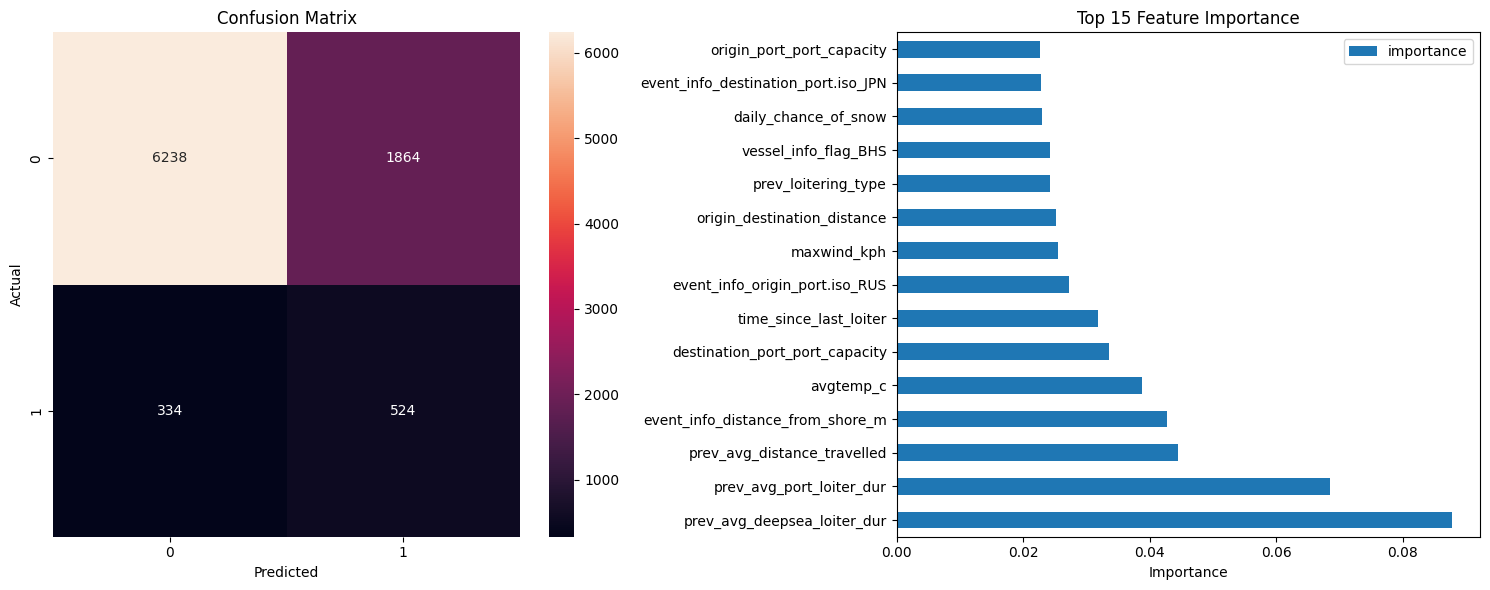

In [77]:
from sklearn.pipeline import Pipeline
from xgboost import XGBClassifier
from scipy.stats import randint, uniform
from sklearn.metrics import (accuracy_score, precision_score, recall_score, 
                           f1_score, roc_auc_score, average_precision_score,
                           confusion_matrix)


print("Optimizing XGBoost model with 150 selected features, and decision threshold = 0.5")
best_model, best_params = optimize_xgb_model(df_processed, best_result['selected_features'], target)

print("\nBest parameters found:")
for param, value in best_params.items():
    clean_param = param.replace('classifier__', '')
    print(f"{clean_param}: {value}")

print("\nEvaluating optimized model...")
metrics, conf_matrix, feature_importance = evaluate_optimized_model(
    best_model, 
    df_processed, 
    best_result['selected_features'], 
    target
)

# Display final results
print("\nOptimized Model Performance Metrics:")
print(metrics)

# Plot final results
fig = plot_results(conf_matrix, feature_importance)
plt.show()

# SMOTE

Optimizing XGBoost model with SMOTE...
Fitting 5 folds for each of 100 candidates, totalling 500 fits

Best parameters found: {'colsample_bytree': 0.6082762640483971, 'learning_rate': 0.02853756102643834, 'max_depth': 7, 'n_estimators': 326, 'scale_pos_weight': 1.0, 'subsample': 0.6330848488391084, 'smote__k_neighbors': 5}

Evaluating thresholds...


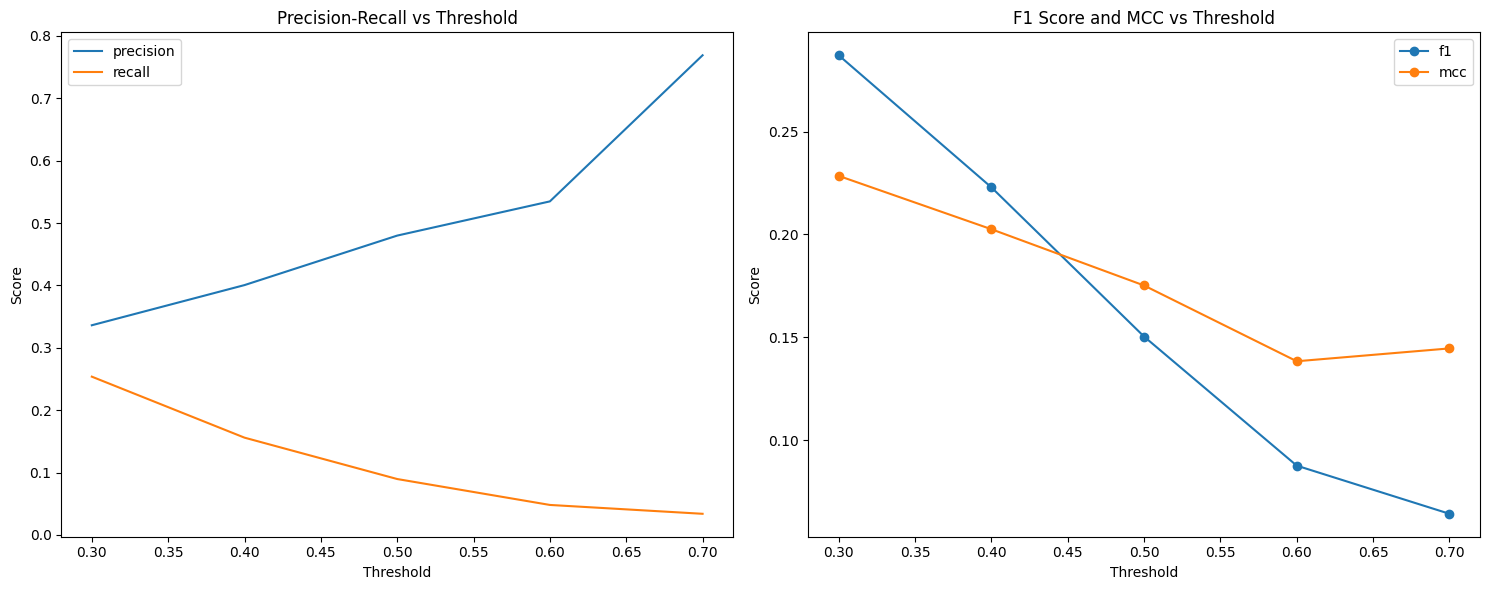


Best threshold based on MCC: 0.3

Final evaluation with best threshold...

Final Performance Metrics:
accuracy: 0.8825
precision: 0.3361
recall: 0.2537
f1: 0.2871
pr_auc: 0.2912
MCC: 0.2285


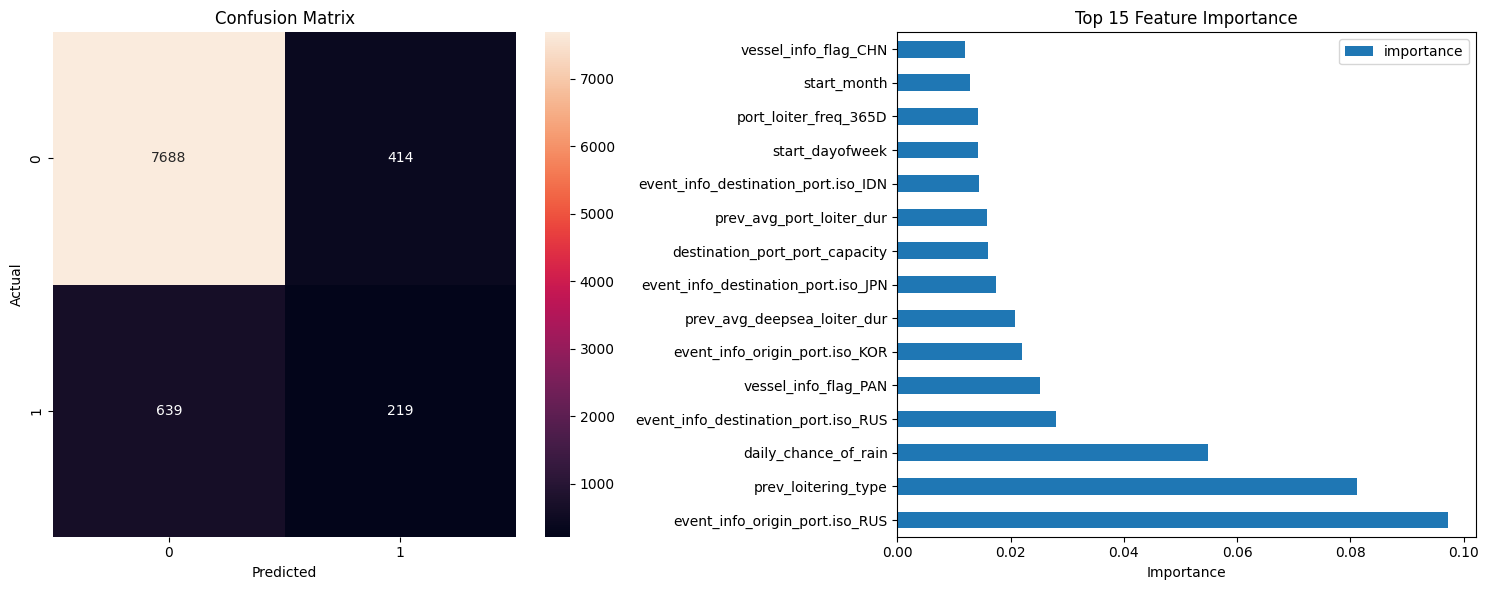

In [57]:
# from imblearn.pipeline import Pipeline  # Change from sklearn.pipeline
# from imblearn.over_sampling import SMOTE
# from xgboost import XGBClassifier
# from scipy.stats import randint, uniform
# from sklearn.metrics import (accuracy_score, precision_score, recall_score, 
#                            f1_score, roc_auc_score, average_precision_score,
#                            confusion_matrix)


# def optimize_xgb_model(df, features, target, n_splits=5, n_iter=100):
#     """
#     Optimize Gradient Boosting model using RandomizedSearchCV with time series split.
#     Includes SMOTE for handling class imbalance.
#     """
#     # Prepare data
#     X = df[features].values
#     y = df[target].values

#     # Define parameter space
#     param_distributions = {
#         'smote__k_neighbors': randint(3, 7),  # Add SMOTE parameters
#         'classifier__n_estimators': randint(100, 500),
#         'classifier__learning_rate': uniform(0.01, 0.3),
#         'classifier__max_depth': randint(3, 10),
#         'classifier__subsample': uniform(0.6, 0.4),
#         'classifier__colsample_bytree': uniform(0.6, 0.4),
#         'classifier__scale_pos_weight': [1.0]  # Set to 1 since SMOTE will balance classes
#     }

#     # Create pipeline with SMOTE
#     pipeline = Pipeline([
#         ('smote', SMOTE(random_state=RANDOM_STATE)),
#         ('classifier', XGBClassifier(random_state=RANDOM_STATE, eval_metric='logloss'))
#     ])

#     # Rest of the function remains the same
#     tscv = TimeSeriesSplit(n_splits=n_splits)

#     random_search = RandomizedSearchCV(
#         estimator=pipeline,
#         param_distributions=param_distributions,
#         n_iter=n_iter,
#         cv=tscv,
#         scoring='average_precision',
#         random_state=RANDOM_STATE,
#         n_jobs=-1,
#         verbose=1
#     )

#     random_search.fit(X, y)

#     return random_search.best_estimator_, random_search.best_params_
    

# def evaluate_model(y_true, y_pred, y_pred_proba):
#     """
#     Calculate various metrics for model evaluation.
#     """
#     metrics = {
#         'accuracy': accuracy_score(y_true, y_pred),
#         'precision': precision_score(y_true, y_pred),
#         'recall': recall_score(y_true, y_pred),
#         'f1': f1_score(y_true, y_pred),
#         'pr_auc': average_precision_score(y_true, y_pred_proba),
#         'MCC': matthews_corrcoef(y_true, y_pred),
#     }
    
#     conf_matrix = confusion_matrix(y_true, y_pred)
    
#     return metrics, conf_matrix


# def evaluate_optimized_model(model, df, features, target, n_splits=5, threshold=0.5):
#     """
#     Evaluate the optimized model using time series cross-validation.
#     """
#     X = df[features].values
#     y = df[target].values

#     tscv = TimeSeriesSplit(n_splits=n_splits)
#     results = []
#     confusion_matrices = np.zeros((2, 2))
#     feature_importances = []
#     class_distributions = {'original': [], 'resampled': []}

#     for train_idx, val_idx in tscv.split(X):
#         X_train, X_val = X[train_idx], X[val_idx]
#         y_train, y_val = y[train_idx], y[val_idx]

#         # Record original class distribution
#         class_distributions['original'].append(
#             pd.Series(y_train).value_counts(normalize=True)
#         )

#         # Fit the model (SMOTE is applied within the pipeline)
#         model.fit(X_train, y_train)

#         # Record resampled class distribution
#         X_resampled, y_resampled = model.named_steps['smote'].fit_resample(X_train, y_train)
#         class_distributions['resampled'].append(
#             pd.Series(y_resampled).value_counts(normalize=True)
#         )

#         # Collect feature importances
#         classifier = model.named_steps['classifier']
#         feature_importances.append(classifier.feature_importances_)

#         # Get predictions
#         y_pred_proba = model.predict_proba(X_val)[:, 1]
#         y_pred = (y_pred_proba >= threshold).astype(int)

#         metrics, conf_matrix = evaluate_model(y_val, y_pred, y_pred_proba)
#         results.append(metrics)
#         confusion_matrices += conf_matrix

#     # Average metrics across folds
#     avg_metrics = pd.DataFrame(results).mean()

#     # Average feature importances across folds
#     avg_feature_importance = np.mean(feature_importances, axis=0)
#     feature_importance_df = pd.DataFrame(
#         avg_feature_importance,
#         index=features,
#         columns=['importance']
#     ).sort_values('importance', ascending=False)

#     return avg_metrics, confusion_matrices, feature_importance_df


# def plot_results(confusion_matrix, feature_importance):
#     """
#     Plot confusion matrix and feature importance.
#     """
#     fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

#     # Plot confusion matrix
#     sns.heatmap(confusion_matrix, annot=True, fmt='g', ax=ax1)
#     ax1.set_title('Confusion Matrix')
#     ax1.set_xlabel('Predicted')
#     ax1.set_ylabel('Actual')

#     # Plot top 15 feature importance
#     feature_importance.head(15).plot(kind='barh', ax=ax2)
#     ax2.set_title('Top 15 Feature Importance')
#     ax2.set_xlabel('Importance')

#     plt.tight_layout()
#     return fig

# # Preprocess data
# df_processed, features, target = preprocess_data(data)

# # Optimize model with SMOTE
# print("Optimizing XGBoost model with SMOTE...")
# best_model, best_params = optimize_xgb_model(df_processed, features, target)
# print("\nBest parameters found:", 
#       {k.replace('classifier__', ''): v for k, v in best_params.items()})

# # Evaluate model with different thresholds
# print("\nEvaluating thresholds...")
# thresholds = [0.3, 0.4, 0.5, 0.6, 0.7]
# threshold_results = {}

# for threshold in thresholds:
#     metrics, conf_matrix, _ = evaluate_optimized_model(
#         best_model, df_processed, features, target, threshold=threshold
#     )
#     threshold_results[threshold] = {
#         'metrics': metrics,
#         'confusion_matrix': conf_matrix
#     }

# # Create results DataFrame for plotting
# results_df = pd.DataFrame({
#     'threshold': thresholds,
#     'precision': [threshold_results[t]['metrics']['precision'] for t in thresholds],
#     'recall': [threshold_results[t]['metrics']['recall'] for t in thresholds],
#     'f1': [threshold_results[t]['metrics']['f1'] for t in thresholds],
#     'pr_auc': [threshold_results[t]['metrics']['pr_auc'] for t in thresholds],
#     'mcc': [threshold_results[t]['metrics']['MCC'] for t in thresholds]
# })

# # Plot results
# fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# # Plot precision-recall trade-off
# results_df.plot(x='threshold', y=['precision', 'recall'], ax=ax1)
# ax1.set_title('Precision-Recall vs Threshold')
# ax1.set_xlabel('Threshold')
# ax1.set_ylabel('Score')

# # Plot F1 score and MCC
# results_df.plot(x='threshold', y=['f1', 'mcc'], ax=ax2, marker='o')
# ax2.set_title('F1 Score and MCC vs Threshold')
# ax2.set_xlabel('Threshold')
# ax2.set_ylabel('Score')

# plt.tight_layout()
# plt.show()

# # Find best threshold based on multiple metrics
# best_threshold = thresholds[results_df['f1'].argmax()]
# print(f"\nBest threshold based on F1 score: {best_threshold}")

# # Final evaluation with best threshold
# print("\nFinal evaluation with best threshold...")
# final_metrics, final_conf_matrix, feature_importance = evaluate_optimized_model(
#     best_model, df_processed, features, target, threshold=best_threshold
# )

# # Display and plot final results
# print("\nFinal Performance Metrics:")
# for metric, value in final_metrics.items():
#     print(f"{metric}: {value:.4f}")

# plot_results(final_conf_matrix, feature_importance)
# plt.show()